In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

### Load dataset and calculate overlap

In [2]:
#DATA_PATH_PPI = "./NBFNet/data/lnctard/train1-ppi.txt" # overlap message passing set
SPLITS = {
  "test":"./NBFNet/data/lnctard/test.txt",
  "train":"./NBFNet/data/lnctard/train.txt",
  "valid":"./NBFNet/data/lnctard/valid.txt",
  "train1-ppi":"./NBFNet/data/lnctard/train1-ppi.txt",
}
PATH_ENTITY_TYPES = "./NBFNet/data/lnctard/entity_types_lnctardppi.txt" # check how many are nan

In [3]:
def check_node_overlap(df_ppi, df_2check):
    df_ppi["index"], df_2check["index"] = df_ppi.index, df_2check.index
    df_ppi['key'] = df_ppi[["head", "tail"]].apply(lambda row: tuple(sorted(row)), axis=1)
    df_2check['key'] = df_2check[["head", "tail"]].apply(lambda row: tuple(sorted(row)), axis=1)
    overlap = pd.merge(df_ppi, df_2check, how='inner', on="key")
    return overlap

In [4]:
dfs = {}
for k, path in SPLITS.items():
    df = pd.read_csv(path, names=["head", "relation", "tail"], sep="\t")
    df['key'] = df[["head", "tail"]].apply(lambda row: tuple(sorted(row)), axis=1)
    dfs[k] = df

In [5]:
overlaps = {}
for k, path in SPLITS.items():
    if k == "train1-ppi": continue
    overlaps[k] = check_node_overlap(dfs[k], dfs["train1-ppi"])

In [6]:
for k, o in overlaps.items():
    print("set",k,": # of overlapping tuples",len(o))

set test : # of overlapping tuples 3
set train : # of overlapping tuples 23
set valid : # of overlapping tuples 0


In [10]:
all_relations = set()
for k, df in dfs.items():
    if k == "train1-ppi": continue
    all_relations |= set(df["relation"].drop_duplicates().tolist())
all_relations = list(all_relations)
all_relations

['interact with mRNA',
 'expression association',
 'transcriptional regulation',
 'ceRNA or sponge',
 'chromatin looping',
 'epigenetic regulation',
 'interact with protein']

### Quantify unique head/tail pairs per relation

_Report_ We observe that relation types like "interact with mRNA" have only very few members. Therefore, they may be learned by heart by the model.

observation: given a relation type, there are only very few triplets with the same node types.

conclusion: we wonder whether our model can actually generalize based on the node type. 

In [11]:
df.head()

,head,relation,tail,key,index
0,BABAM1,interacts-with,PSMD14,"(BABAM1, PSMD14)",0
1,GADD45GIP1,in-complex-with,MRPL58,"(GADD45GIP1, MRPL58)",1
2,H4C3,interacts-with,H2AC21,"(H2AC21, H4C3)",2
3,LCK,in-complex-with,STAT1,"(LCK, STAT1)",3
4,RFC4,in-complex-with,ZNF830,"(RFC4, ZNF830)",4


In [12]:
df_entities = pd.read_csv(PATH_ENTITY_TYPES, sep="\t", names=["entity name","entity type index"])

In [18]:
df_entities.head()

,entity name,entity type index
0,14-3-3alpha,0
1,14-3-3beta,0
2,91H,0
3,A2M-AS1,2
4,AATBC,2


In [19]:
df.head()

,head,relation,tail,key,index
0,BABAM1,interacts-with,PSMD14,"(BABAM1, PSMD14)",0
1,GADD45GIP1,in-complex-with,MRPL58,"(GADD45GIP1, MRPL58)",1
2,H4C3,interacts-with,H2AC21,"(H2AC21, H4C3)",2
3,LCK,in-complex-with,STAT1,"(LCK, STAT1)",3
4,RFC4,in-complex-with,ZNF830,"(RFC4, ZNF830)",4


In [46]:
for df in df

SyntaxError: invalid syntax (1122610957.py, line 2)

In [52]:
dfs_merged = {}
for key, df in dfs.items():
    mapped_types = []
    merged_heads = pd.merge(df_entities, df, left_on='entity name', right_on="head", how='inner')
    merged_tailes = pd.merge(df_entities, df, left_on='entity name', right_on="tail", how='inner')
    merged_all = pd.merge(df_entities, merged_heads, left_on='entity name', right_on="tail", how='inner')
    dfs_merged = {key: merged_all}

In [53]:
dfs_merged["test"].head()

KeyError: 'test'

In [38]:
merged_all["key"] = merged_all[["entity type index_x", "entity type index_y"]].apply(lambda row: tuple(sorted(row)), axis=1)

In [39]:
merged_all.head()

,entity name_x,entity type index_x,entity name_y,entity type index_y,head,relation,tail,key,index
0,ABCA1,1,ACE2,1,ACE2,catalysis-precedes,ABCA1,"(1, 1)",823529
1,ABCA1,1,ACE2,41,ACE2,catalysis-precedes,ABCA1,"(1, 41)",823529
2,ABCA1,1,AGER,1,AGER,catalysis-precedes,ABCA1,"(1, 1)",722422
3,ABCA1,1,AGER,41,AGER,catalysis-precedes,ABCA1,"(1, 41)",722422
4,ABCA1,1,ANPEP,1,ANPEP,catalysis-precedes,ABCA1,"(1, 1)",574877


relation
catalysis-precedes             3
controls-phosphorylation-of    5
controls-transport-of          5
in-complex-with                6
controls-state-change-of       8
controls-expression-of         9
interacts-with                 9
Name: key, dtype: int64
['interact with mRNA', 'expression association', 'transcriptional regulation', 'ceRNA or sponge', 'chromatin looping', 'epigenetic regulation', 'interact with protein']
relation
catalysis-precedes             3
controls-phosphorylation-of    5
controls-transport-of          5
in-complex-with                6
controls-state-change-of       8
controls-expression-of         9
interacts-with                 9
Name: key, dtype: int64
['interact with mRNA', 'expression association', 'transcriptional regulation', 'ceRNA or sponge', 'chromatin looping', 'epigenetic regulation', 'interact with protein']
relation
catalysis-precedes             3
controls-phosphorylation-of    5
controls-transport-of          5
in-complex-with           

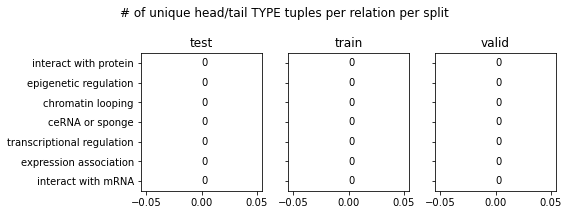

In [44]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(8,3))
for idx, (ax, (k, df)) in enumerate(zip(axs, dfs.items())):
    if k == "train1-ppi": continue
    counts = merged_all.groupby(by="relation")['key'].nunique().sort_values()
    col = []
    print(counts)
    for rel in all_relations:
        col += [counts[rel] if rel in counts.index else 0]
    print(all_relations)
    df = pd.DataFrame({k:col}, index=all_relations)
    ax.set_title(k)
    df.plot.barh(ax=ax, legend=False)
    for cont in ax.containers:
        ax.bar_label(cont)
fig.suptitle("# of unique head/tail TYPE tuples per relation per split")
fig.tight_layout()

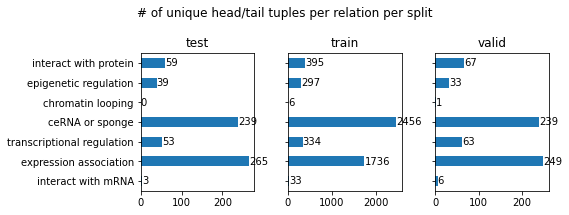

In [8]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(8,3))
for idx, (ax, (k, df)) in enumerate(zip(axs, dfs.items())):
    if k == "train1-ppi": continue
    counts = df.groupby(by="relation")['key'].nunique().sort_values()
    col = []
    for rel in all_relations:
        col += [counts[rel] if rel in counts.index else 0]
    df = pd.DataFrame({k:col}, index=all_relations)
    ax.set_title(k)
    df.plot.barh(ax=ax, legend=False)
    for cont in ax.containers:
        ax.bar_label(cont)
fig.suptitle("# of unique head/tail tuples per relation per split")
fig.tight_layout()

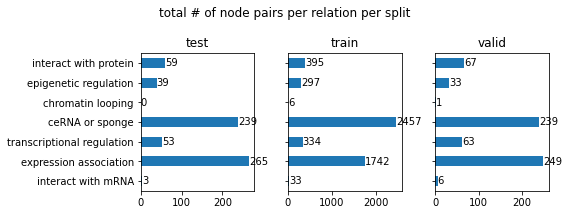

In [9]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(8,3))
for idx, (ax, (k, df)) in enumerate(zip(axs, dfs.items())):
    if k == "train1-ppi": continue
    counts = df.groupby(by="relation")['key'].size().sort_values()
    col = []
    for rel in all_relations:
        col += [counts[rel] if rel in counts.index else 0]
    df = pd.DataFrame({k:col}, index=all_relations)
    ax.set_title(k)
    df.plot.barh(ax=ax, legend=False)
    for cont in ax.containers:
        ax.bar_label(cont)
fig.suptitle("total # of node pairs per relation per split")
fig.tight_layout()

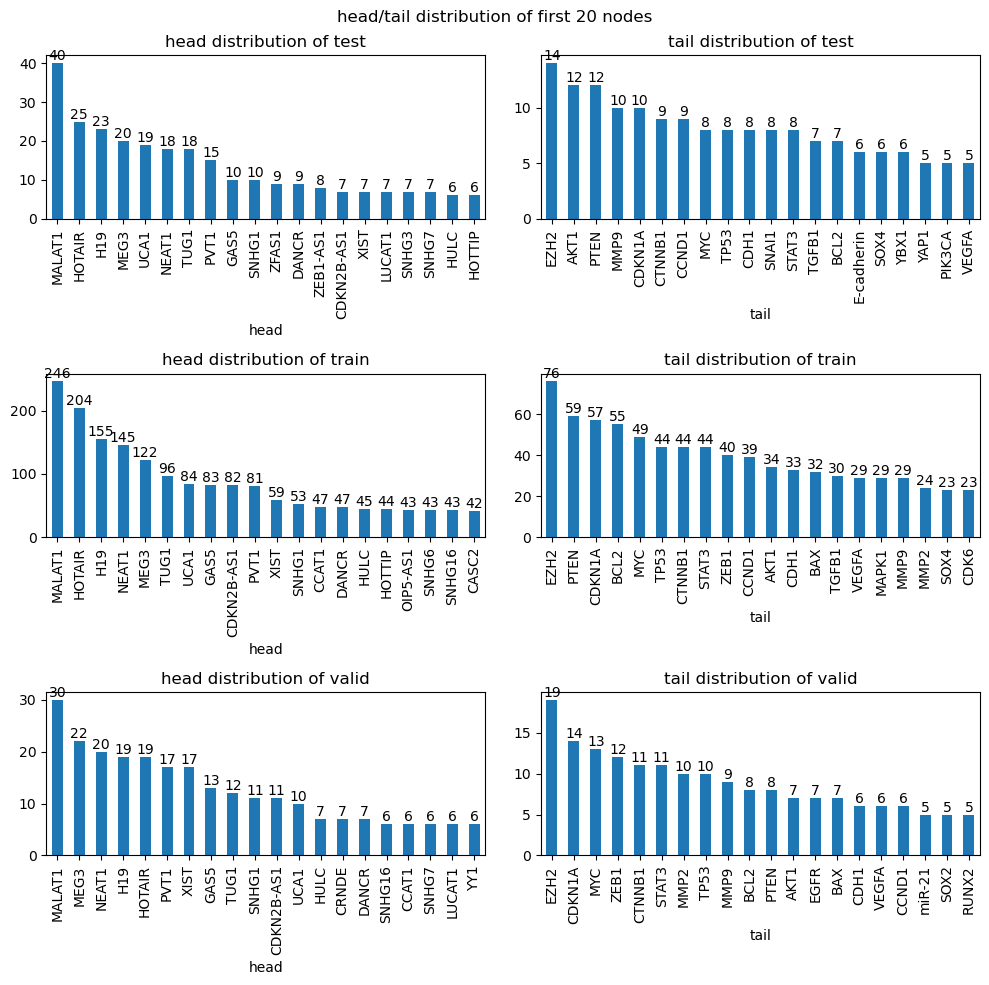

In [178]:
fig,axs = plt.subplots(nrows=3,ncols=2, figsize=(10,10))
for split_idx, (k, df) in enumerate(dfs.items()):
  if k == "train1-ppi": continue
  heads = df.groupby(by="head").size().sort_values(ascending=False)
  tails = df.groupby(by="tail").size().sort_values(ascending=False)
  cutoff = 20
  axs.flat[split_idx * 2 + 0].set_title("head distribution of %s" % k)
  heads[:cutoff].plot(kind="bar",ax=axs.flat[split_idx * 2 + 0])
  axs.flat[split_idx * 2 + 1].set_title("tail distribution of %s" % k)
  tails[:cutoff].plot(kind="bar",ax=axs.flat[split_idx * 2 + 1])
for ax in axs.flat:
  for cont in ax.containers:
    ax.bar_label(cont)
fig.suptitle("head/tail distribution of first %d nodes" % cutoff)
fig.tight_layout()

### Inspect overlap

In [186]:
df_entities = pd.read_csv(PATH_ENTITY_TYPES, sep="\t", names=["entity name","entity type index"])

In [187]:
nan_ent = (df_entities["entity type index"] == 0).sum()
tot_ent = len(df_entities["entity type index"])
f'nan entities: {nan_ent}/{tot_ent}={100.*nan_ent/tot_ent:.02f}%'

'nan entities: 763/22039=3.46%'

In [179]:
overlaps.keys()

dict_keys(['test', 'train', 'valid'])

In [205]:
overlaps["test"][["head_x","tail_x"]]

,head_x,tail_x
0,AGO2,PIK3CA
1,TUG1,FOXA1
2,TUG1,MYC


In [211]:
overlaps["train"][["head_x","tail_x"]]

,head_x,tail_x
0,LINC01138,SP1
1,POU3F3,FOXD1
2,SCAMP1,JUN
3,SOD2,BAX
4,SOD2,BAX
5,ZNF281,NANOG
6,RAB5IF,MYC
7,AGO2,PTEN
8,AGO2,PTEN
9,TUG1,ZEB1


In [207]:
overlaps["valid"][["head_x","tail_x"]]

,head_x,tail_x


### Data leakage

In [222]:
print(f'PPI->train: {len(overlaps["train"][["head_x","tail_x"]]) / len(dfs["train"]) * 100.:.02f}%')
print(f'PPI->valid: {len(overlaps["valid"][["head_x","tail_x"]]) / len(dfs["valid"]) * 100.:.02f}%')
print(f'PPI->test: {len(overlaps["test"][["head_x","tail_x"]]) / len(dfs["test"]) * 100.:.02f}%')

PPI->train: 0.44%
PPI->valid: 0.00%
PPI->test: 0.46%


### Inspect "nan" type heads or tails

In [202]:
print("# of heads or tails that are unknown in triplets")
for k, df in dfs.items():
  if k == "train1-ppi": continue
  for which in ["head", "tail"]:
    tys = pd.merge(df, df_entities, how="outer", left_on=which, right_on="entity name")["entity type index"]
    ab, tot = (tys == 0).sum(), len(tys)
    print(k, which, ab, "/", tot, f"= {100.*ab/tot:.02f}%")

# of heads or tails that are unknown in triplets
test head 774 / 22482 = 3.44%
test tail 797 / 22607 = 3.53%
train head 1181 / 27269 = 4.33%
train tail 1179 / 27192 = 4.34%
valid head 776 / 22496 = 3.45%
valid tail 802 / 22621 = 3.55%
